In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import pandas as pd

df=pd.read_csv("D:\Thesis\messy work\Final.csv")
df['TURBIDITY']=pd.to_numeric(df['TURBIDITY'],errors='coerce')
df['Labels']=df.Labels.astype(float)
df=df[['TEMPL','PHL','EC','CHLORIDE','TALKAL','TURBIDITY','DO','BOD','Labels']]

XRaw=np.array(df)
XRaw=np.random.permutation(XRaw)

def norm(X):
    meanAr=np.mean(X,axis=1)
    meanAr=np.reshape(meanAr,(meanAr.shape[0],1))
    varAr=np.var(X,axis=1)
    varAr=np.reshape(varAr,(varAr.shape[0],1))
    normX=np.divide(np.subtract(X,meanAr),varAr)
    return normX,meanAr,varAr

def normRet(X,XTrainMean,XTrainVar):
    normX=np.divide(np.subtract(X,XTrainMean),XTrainVar)
    return normX

In [9]:
Val=XRaw[0:400,:]
Test=XRaw[400:800,:]
Train=XRaw[800:-1,:]

def oneHot(labels,C):
    C=tf.constant(C)
    oneHotMat=tf.one_hot(labels,C,axis=0)
    sess=tf.Session()
    oneHot=sess.run(oneHotMat)
    sess.close()
    return oneHot

XTrainR=np.transpose(Train[:,0:-1])
XTrain,Xmean,Xvar=norm(XTrainR)
YTrain=Train[:,-1]
YTrain=np.transpose(YTrain)    #No need to reshape as one_hot handles the the missing dimension automatically
YTrain=oneHot(YTrain,10)

XTestR=np.transpose(Test[:,0:-1])
XTest=normRet(XTestR,Xmean,Xvar)
YTest=Test[:,-1]
YTest=np.transpose(YTest)
YTest=oneHot(YTest,10)

XValR=np.transpose(Val[:,0:-1])
XVal=normRet(XValR,Xmean,Xvar)
YVal=Val[:,-1]
YVal=np.transpose(YVal)
YVal=oneHot(YVal,10)


In [10]:
print(XTrainR,XTrainR.shape)
print(YTrain,YTrain.shape)
print(XTrain,XTrain.shape)

[[  2.85000000e+01   2.70000000e+01   2.80000000e+01 ...,   2.90000000e+01
    2.50000000e+01   2.45000000e+01]
 [  8.25000000e+00   6.99000000e+00   7.10000000e+00 ...,   7.38000000e+00
    6.70000000e+00   8.35000000e+00]
 [  1.02200000e+03   1.72000000e+02   3.26000000e+02 ...,   1.20000000e+02
    1.16000000e+02   3.20800000e+03]
 ..., 
 [  3.50000000e+00   6.00000000e+00   6.00000000e+00 ...,   8.00000000e+00
    3.20000000e+01   3.50000000e+00]
 [  5.20000000e+00   5.90000000e+00   4.60000000e+00 ...,   4.80000000e+00
    6.30000000e+00   5.00000000e+00]
 [  3.60000000e+00   2.60000000e+00   8.40000000e+00 ...,   2.20000000e+00
    2.30000000e+00   1.50000000e+01]] (8, 3194)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  1.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]] (10, 3194)
[[  1.13603780e-01  -8.81008389e-02   4.63689069e-02 ...,   1.80838653e-01
   -3.57040330e-01  -4.2

In [11]:

def createPlace(nX,nY):
    X=tf.placeholder(tf.float32,shape=(nX,None))
    Y=tf.placeholder(tf.float32,shape=(nY,None))
    return X,Y

def initParameters():
    W1=tf.get_variable("W1",[15,8],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    b1=tf.get_variable("b1",[15,1],initializer=tf.zeros_initializer(),dtype=tf.float32)
    W2=tf.get_variable("W2",[15,15],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    b2=tf.get_variable("b2",[15,1],initializer=tf.zeros_initializer(),dtype=tf.float32)
    W3=tf.get_variable("W3",[10,15],initializer=tf.contrib.layers.xavier_initializer(),dtype=tf.float32)
    b3=tf.get_variable("b3",[10,1],initializer=tf.zeros_initializer(),dtype=tf.float32)

    parameters = {"W1":W1,
                  "b1":b1,
                  "W2":W2,
                  "b2":b2,
                  "W3":W3,
                  "b3":b3}
    return parameters

def forward(X,parameters):
    W1=parameters['W1']
    b1=parameters['b1']
    W2=parameters['W2']
    b2=parameters['b2']
    W3=parameters['W3']
    b3=parameters['b3']

    Z1=tf.add(tf.matmul(W1,X),b1)
    A1=tf.nn.relu(Z1)
    Z2=tf.add(tf.matmul(W2,A1),b2)
    A2=tf.nn.relu(Z2)
    Z3=tf.add(tf.matmul(W3,A2),b3)

    return Z3

def compCost(Z3,Y):
    logits=tf.transpose(Z3)
    labels=tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [12]:
def model(XTrainR,YTrain,XValR,YVal,learning_rate=.001,num_epochs=1000,print_cost=True):
    ops.reset_default_graph()
    (nX,m)=XTrainR.shape
    nY=YTrain.shape[0]
    costs=[]

    X,Y=createPlace(nX,nY)
    parameters=initParameters()
    Z3=forward(X,parameters)
    cost=compCost(Z3,Y)

    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        print(XTrainR)
        print(YTrain)
        for epoch in range(num_epochs):
            epoch_cost=0
            _,epoch_cost=sess.run([optimizer,cost],feed_dict={X:XTrainR,Y:YTrain})
            #print(epoch_cost)
            if print_cost==True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch,epoch_cost))
            if print_cost==True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate ="+str(learning_rate))
        plt.show()

        parameters=sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction=tf.equal(tf.argmax(Z3),tf.argmax(Y))

        accuracy=tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:",accuracy.eval({X:XTrainR,Y:YTrain}))
        print ("Test Accuracy:", accuracy.eval({X:XValR,Y:YVal}))

        return parameters



[[  1.13603780e-01  -8.81008389e-02   4.63689069e-02 ...,   1.80838653e-01
   -3.57040330e-01  -4.24275203e-01]
 [  4.18438332e+00  -1.02970964e+00  -5.74511047e-01 ...,   5.84176276e-01
   -2.22977865e+00   4.59820022e+00]
 [  5.61847375e-04  -3.81291616e-04  -2.10417022e-04 ...,  -4.38989530e-04
   -4.43427832e-04   2.98737895e-03]
 ..., 
 [ -8.13481509e-03  -7.09818645e-03  -7.09818645e-03 ...,  -6.26888353e-03
    3.68275146e-03  -8.13481509e-03]
 [ -6.06373663e-02   7.70687246e-02  -1.78671159e-01 ...,  -1.39326561e-01
    1.55757919e-01  -9.99819637e-02]
 [ -3.41557604e-03  -4.09390008e-03  -1.59620648e-04 ...,  -4.36522970e-03
   -4.29739729e-03   4.31731802e-03]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  1.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Cost after epoch 0: 2.337181
Cost after epoch 100: 1.838947
Cost after epoch 200: 1.646588
Cost after epoch 300: 1.59651

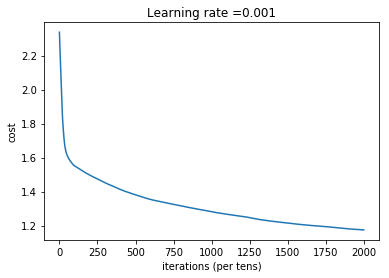

Parameters have been trained!
Train Accuracy: 0.578272
Test Accuracy: 0.5575


In [13]:
parameters=model(XTrain,YTrain,XVal,YVal,learning_rate=.001,num_epochs=10000,print_cost=True)